In [ ]:
!pip install livelossplot
!pip install pycm
!pip install torchsummary
!pip install xarray
!pip install netCDF4
!pip install h5netcdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.4/610.4 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 99.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torchsummary import summary

import xarray as xr

import os
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
X_file_path = "/content/drive/MyDrive/ice_challenge_test/X"
Y_file_path = "/content/drive/MyDrive/ice_challenge_test/y"

X_dict = {}
Y_dict = {}

for file in os.listdir(X_file_path):
    if file.endswith(".nc"):
        # Read file
        ds = xr.open_dataset(os.path.join(X_file_path, file))
        scene_name = file.split("_")[0]
        X_dict[scene_name] = ds

for scene_name in X_dict.keys():
    y_file_full_path = os.path.join(Y_file_path, scene_name + "_dmi_prep_reference.nc")
    if os.path.exists(y_file_full_path):
        ds = xr.open_dataset(y_file_full_path)
        Y_dict[scene_name] = ds
    else:
        print(f"Warning: Y file not found for scene {scene_name}: {y_file_full_path}")

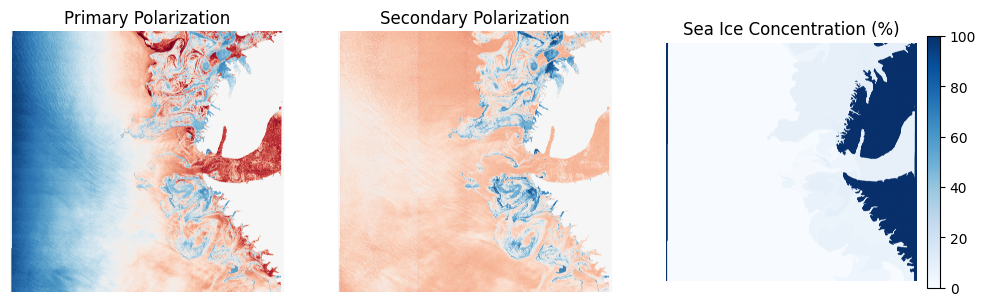

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (12, 6))

key = "20201013T080448"

axs[0].imshow(X_dict[key].nersc_sar_primary, vmin = -2, vmax = 2, cmap = "RdBu")
axs[0].set_title("Primary Polarization")

axs[1].imshow(X_dict[key].nersc_sar_secondary, vmin = -2, vmax = 2, cmap = "RdBu")
axs[1].set_title("Secondary Polarization")

axs[2].imshow(Y_dict[key].SIC, cmap = "Blues", vmin = 0, vmax = 100)
axs[2].set_title("Sea Ice Concentration (%)")
axs[2].colorbar = plt.colorbar(axs[2].images[0], ax = axs[2], fraction=0.046, pad=0.04)

[ax.axis('off') for ax in axs]

plt.show()


In [ ]:
def patchify(key, patch_size, patch_num):
    X = np.empty((patch_num, patch_size, patch_size, 2))
    y = np.empty((patch_num, patch_size, patch_size))

    data = np.dstack((X_dict[key].nersc_sar_primary.values, X_dict[key].nersc_sar_secondary.values))
    label = Y_dict[key].SIC.values

    (t_max, x_max, _) = data.shape

    for n in range(patch_num):

        # Select random point in data (not at the edge)
        x_n = random.randint(patch_size//2,x_max-patch_size//2)
        t_n = random.randint(patch_size//2,t_max-patch_size//2)

        # Extract patch
        X[n] = data[t_n-patch_size//2:t_n+patch_size//2, x_n-patch_size//2:x_n+patch_size//2, :]
        y[n] = label[t_n-patch_size//2:t_n+patch_size//2, x_n-patch_size//2:x_n+patch_size//2]

        # repeat if more than 50% of the patch is 255 (no data)
        while np.sum(y[n] == 255) > 0.9 * patch_size * patch_size:
            x_n = random.randint(patch_size//2,x_max-patch_size//2)
            t_n = random.randint(patch_size//2,t_max-patch_size//2)
            X[n] = data[t_n-patch_size//2:t_n+patch_size//2, x_n-patch_size//2:x_n+patch_size//2, :]
            y[n] = label[t_n-patch_size//2:t_n+patch_size//2, x_n-patch_size//2:x_n+patch_size//2]

    return X, y

patch_size = 128

X_train = np.empty((0, patch_size, patch_size, 2))
y_train = np.empty((0, patch_size, patch_size))

for key in X_dict.keys():
        X_p, y_p = patchify(key, patch_size, 500)
        X_train = np.vstack((X_train, X_p))
        y_train = np.vstack((y_train, y_p))

y_train = np.expand_dims(y_train, axis=-1) # Add a channel dimension for y_train

In [ ]:
X_train.shape, y_train.shape

((3500, 128, 128, 2), (3500, 128, 128, 1))

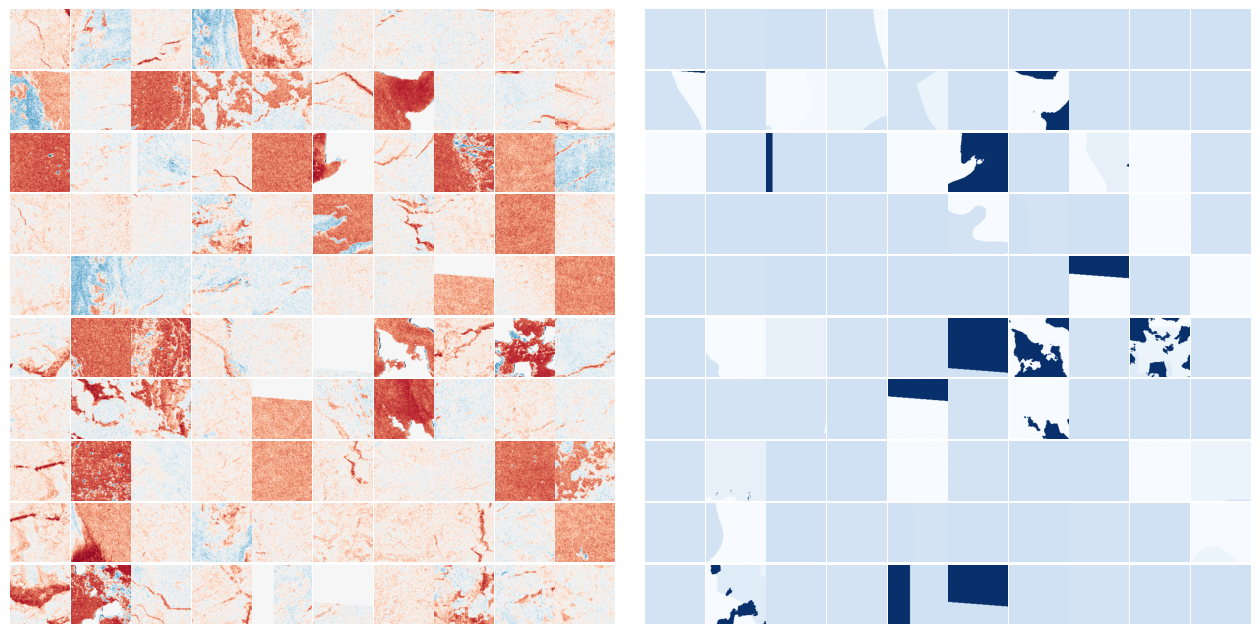

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

dim = 10

fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.05)

# --------------------
# Left: X_train
# --------------------
gs_left = gridspec.GridSpecFromSubplotSpec(
    dim, dim, subplot_spec=gs[0], wspace=0.02, hspace=0.02
)

for i in range(dim**2):
    ax = fig.add_subplot(gs_left[i])
    ax.imshow(X_train[i][:, :, 0], cmap="RdBu", vmin=-2, vmax=2)
    ax.axis("off")

# --------------------
# Right: y_train
# --------------------
gs_right = gridspec.GridSpecFromSubplotSpec(
    dim, dim, subplot_spec=gs[1], wspace=0.02, hspace=0.02
)

for i in range(dim**2):
    ax = fig.add_subplot(gs_right[i])
    ax.imshow(y_train[i], cmap="Blues", vmin=0, vmax=50)
    ax.axis("off")

plt.show()


In [ ]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 100
n_epochs = 10

In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [ ]:
ice_train = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train / 100))
train_loader = DataLoader(ice_train, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
class IceDataset(Dataset):
    def __init__(self, X_dict, Y_dict, transform=None):
        self.X_dict = X_dict
        self.Y_dict = Y_dict
        self.transform = transform
        self.scene_names = list(X_dict.keys())

    def __len__(self):
        return len(self.scene_names)

    def __getitem__(self, idx):
        scene_name = self.scene_names[idx]
        X = self.X_dict[scene_name].to_array().values  # Convert xarray to numpy array
        Y = self.Y_dict[scene_name]['ice_conc'].values  # Assuming 'ice_conc' is the variable name

        if self.transform:
            X = self.transform(X)
            Y = self.transform(Y)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

In [ ]:
# ================================================
# Convolutional, Encoder, and Decoder blocks
# ================================================

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.GroupNorm(16, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class EncBlock(nn.Module):

    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv_block1 = ConvBlock(in_c, out_c)
        self.conv_block2 = ConvBlock(out_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        h = self.conv_block1(x)
        h = self.conv_block2(h)
        p = self.pool(h)
        return h, p

class DecBlock(nn.Module):

    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv_block1 = ConvBlock(2*out_c, out_c)
        self.conv_block2 = ConvBlock(out_c, out_c)

    def forward(self, x, s):
        h = self.up(x)
        h = torch.cat([h, s], axis=1) # concatenate skip connection
        h = self.conv_block1(h)
        h = self.conv_block2(h)
        return h

# ================================================
# Full UNet
# ================================================

class UNet_Simple(nn.Module):

    def __init__(self, in_channels, out_channels): # Modified to accept in_channels and out_channels
        super().__init__()

        # encoder
        self.e1 = EncBlock(in_channels, 64) # Use in_channels
        self.e2 = EncBlock(64, 128)
        self.e3 = EncBlock(128, 256)
        self.e4 = EncBlock(256, 512)

        # bottleneck
        self.b1 = ConvBlock(512, 1024)

        # decoder
        self.d4 = DecBlock(1024, 512)
        self.d3 = DecBlock(512, 256)
        self.d2 = DecBlock(256, 128)
        self.d1 = DecBlock(128, 64)

        #	output layer
        self.output = nn.Conv2d(64, out_channels, kernel_size=1, padding=0) # Use out_channels
        self.output_sig = nn.Sigmoid()

    def forward(self, x):

        # encoder
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        # bottleneck
        b = self.b1(p4)

        # decoder
        d4 = self.d4(b, s4)
        d3 = self.d3(d4, s3)
        d2 = self.d2(d3, s2)
        d1 = self.d1(d2, s1)


        # output
        output = self.output(d1)
        output = self.output_sig(output)
        return output

In [ ]:
# ================================================
# Initialise and test
# ================================================

model_unet = UNet_Simple(in_channels=2, out_channels=1).to(device) # Initialized with in_channels=2 and out_channels=1

# Test model
output = model_unet(torch.ones(1, 2, 64, 64).to(device))
print(output.shape)

# Print model
summ = summary(model_unet, input_size=(2, 64, 64))
summ

torch.Size([1, 1, 64, 64])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,216
         GroupNorm-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         ConvBlock-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,928
         GroupNorm-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         ConvBlock-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
         EncBlock-10  [[-1, 64, 64, 64], [-1, 64, 32, 32]]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
        GroupNorm-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
 

In [ ]:
# ================================================
# Train loops
# ================================================

def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.

    for input, target in data_loader:
        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(input.permute(0, 3, 1, 2))
        loss = criterion(output, target.permute(0, 3, 1, 2))
        loss.backward()
        train_loss += loss*input.size(0)
        optimizer.step()
    train_loss = train_loss / len(data_loader.dataset)
    return train_loss


def valid(model, criterion, data_loader):
    model.eval()
    valid_loss = 0.
    with torch.no_grad():
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)
            output = model(input.permute(0, 3, 1, 2))
            loss = criterion(output, target.permute(0, 3, 1, 2))
            valid_loss += loss*input.size(0)
        valid_loss = valid_loss / len(data_loader.dataset)
        return valid_loss


def test(model, data_loader):
    model.eval()
    targets = []
    outputs = []
    with torch.no_grad():
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)
            output = model(input.permute(0, 3, 1, 2))
            targets.append(target)
            outputs.append(output)
        return torch.cat(targets), torch.cat(outputs)

criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model_unet.parameters(), lr=1e-3)

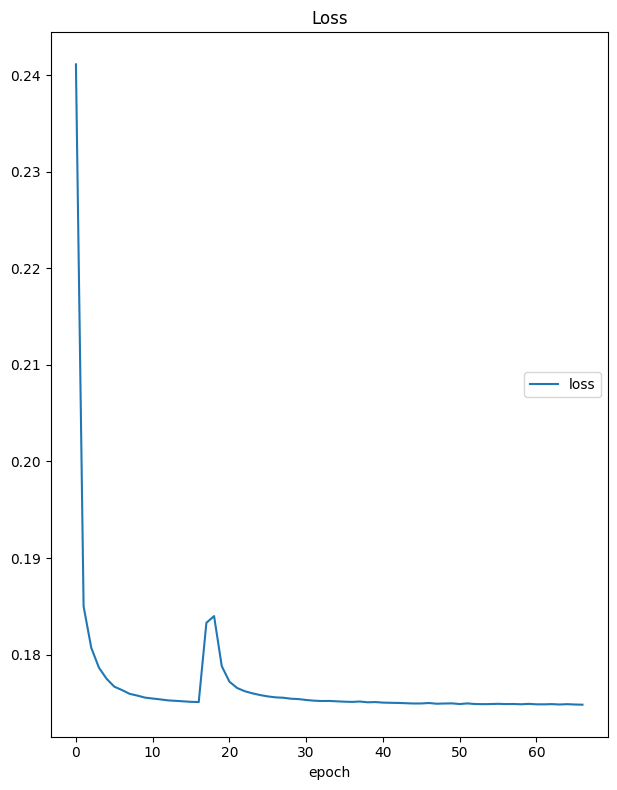

Loss
	loss             	 (min:    0.175, max:    0.241, cur:    0.175)


KeyboardInterrupt: 

In [ ]:
# Run train loop

num_epochs = 100

liveloss = PlotLosses()
for i in range(num_epochs):
    train_loss = train(model_unet, optimiser, criterion, train_loader)

    # Liveloss plot
    logs = {}
    logs['' + 'loss'] = train_loss.item()
    liveloss.update(logs)
    liveloss.draw()


In [ ]:
torch.save(model_unet.state_dict(), "/content/drive/MyDrive/unet_sea_ice_model_2.pth")

In [ ]:
# ==========================================
# Test
# ==========================================

test = xr.open_dataset("/content/drive/MyDrive/ice_challenge_test/X/20201013T080448_dmi_prep.nc")

test_X = np.dstack((test.nersc_sar_primary.values, test.nersc_sar_secondary.values))

test_y = xr.open_dataset("/content/drive/MyDrive/ice_challenge_test/y/20201013T080448_dmi_prep_reference.nc").SIC.values

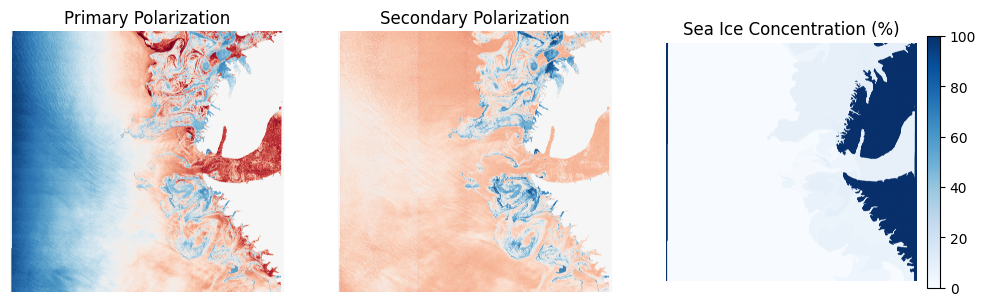

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (12, 6))

axs[0].imshow(test.nersc_sar_primary, vmin = -2, vmax = 2, cmap = "RdBu")
axs[0].set_title("Primary Polarization")

axs[1].imshow(test.nersc_sar_secondary, vmin = -2, vmax = 2, cmap = "RdBu")
axs[1].set_title("Secondary Polarization")

axs[2].imshow(test_y, cmap = "Blues", vmin = 0, vmax = 100)
axs[2].set_title("Sea Ice Concentration (%)")
axs[2].colorbar = plt.colorbar(axs[2].images[0], ax = axs[2], fraction=0.046, pad=0.04)

[ax.axis('off') for ax in axs]

plt.show()


In [ ]:
# ================================================
# Convolution over full data
# ================================================

PATCH  = 128
STRIDE = 64 # smaller stride for more overlap -> but takes longer (haven't really seen many improvements when making it smaller)

device = next(model_unet.parameters()).device
model_unet.eval()

H, W, C = test_X.shape

pred_sum   = np.zeros((H, W), dtype=np.float32)
pred_count = np.zeros((H, W), dtype=np.float32)

with torch.no_grad():
    # Convolve
    for y in range(0, H - PATCH + 1, STRIDE):
        for x in range(0, W - PATCH + 1, STRIDE):

            # Extract patch: (256, 256, 3)
            patch = test_X[y:y+PATCH, x:x+PATCH]

            # convert to nupy
            patch = torch.from_numpy(patch).float()

            patch = patch.permute(2, 0, 1)
            patch = patch.unsqueeze(0).to(device)

            # apply modl
            pred = model_unet(patch)

            pred = pred.squeeze(0).squeeze(0).cpu().numpy()

            pred_sum[y:y+PATCH, x:x+PATCH]   += pred[0, :]
            pred_count[y:y+PATCH, x:x+PATCH] += 1

pred_mask = np.zeros_like(pred_sum)
valid = pred_count > 0
pred_mask[valid] = pred_sum[valid] / pred_count[valid]

# binary_mask = (pred_mask > 0.5).astype(np.uint8)


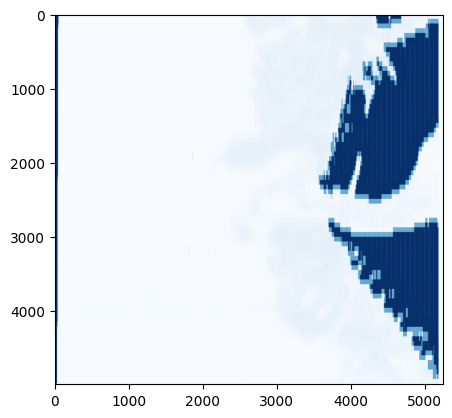

In [ ]:
plt.imshow(pred_mask, cmap = "Blues", vmin = 0, vmax = 1)

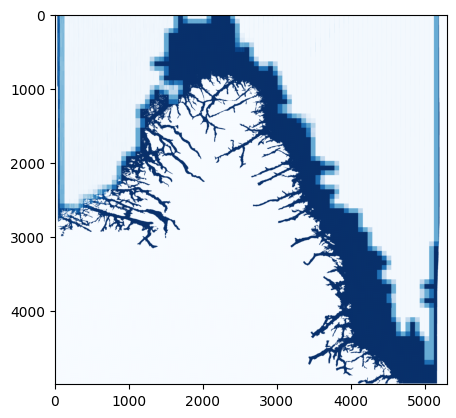

In [ ]:

plt.imshow(np.where(test_y >= 250, 0, pred_mask), cmap = "Blues", vmin = 0, vmax = 1)

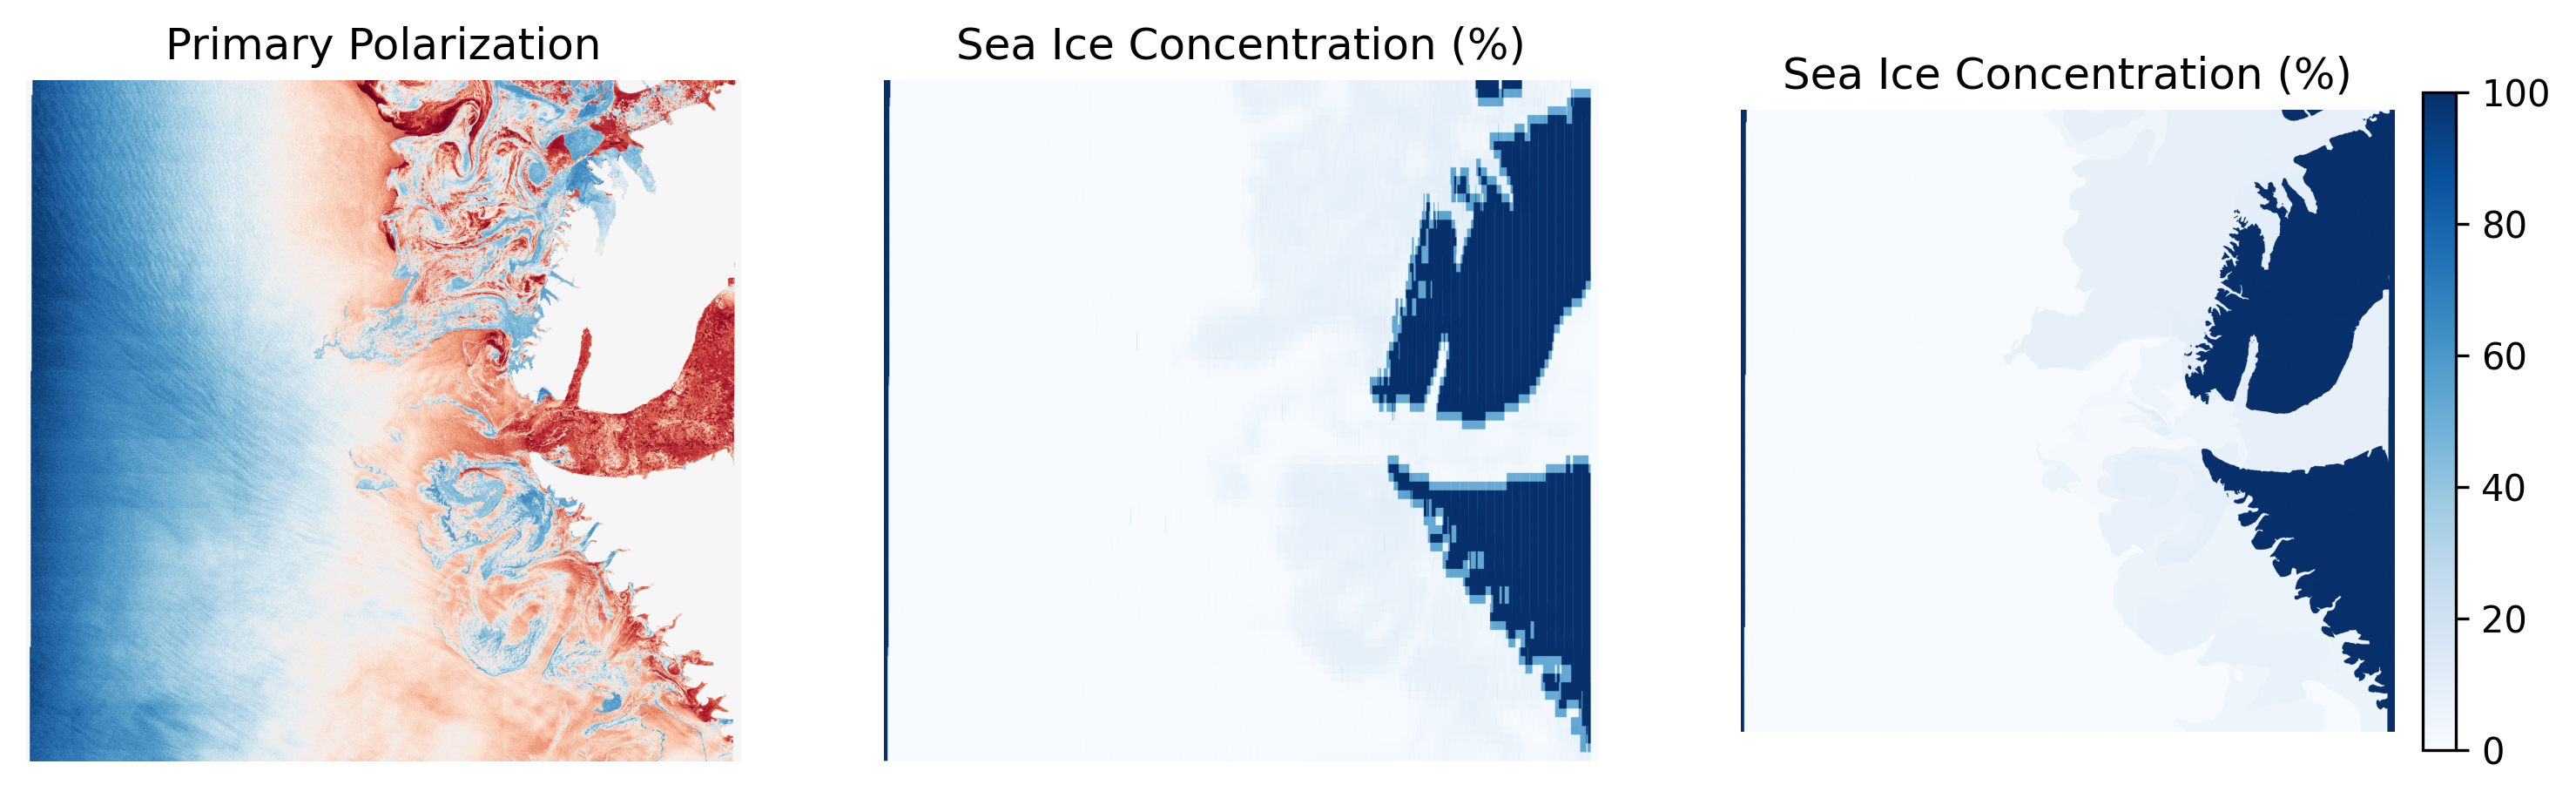

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (12, 6), dpi=300)

axs[0].imshow(test.nersc_sar_primary, vmin = -2, vmax = 2, cmap = "RdBu")
axs[0].set_title("Primary Polarization")

# axs[1].imshow(np.where(test_y >= 250, 2.55, pred_mask), cmap = "Blues", vmin = 0, vmax = 1)
axs[1].imshow(pred_mask, cmap = "Blues", vmin = 0, vmax = 1)
axs[1].set_title("Sea Ice Concentration (%)")

axs[2].imshow(test_y, cmap = "Blues", vmin = 0, vmax = 100)
axs[2].set_title("Sea Ice Concentration (%)")
axs[2].colorbar = plt.colorbar(axs[2].images[0], ax = axs[2], fraction=0.046, pad=0.04)

[ax.axis('off') for ax in axs]

plt.show()


In [ ]:
++